In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
import string
from nltk.stem.snowball import SnowballStemmer

In [2]:
# Reading the data file into a DATAFRAME and checking the shape 
data=pd.read_csv('AmazonMobileDataUncleaned.csv')
print(data.shape)

(71922, 2)


In [3]:
def datapreprocess(sen):
    
    sen = re.sub(r"didn't", "did not", sen)
    sen = re.sub(r"don't", "do not", sen)
    sen = re.sub(r"won't", "will not", sen)
    sen = re.sub(r"can't", "can not", sen)
    sen = re.sub(r"wasn't", "do not", sen)
    sen = re.sub(r"\'ve", " have", sen)
    sen = re.sub(r"\'m", " am", sen)
    sen = re.sub(r"\'ll", " will", sen)
    sen = re.sub(r"\'re", " are", sen)
    sen = re.sub(r"\'s", " is", sen)
    sen = re.sub(r"\'d", " would", sen)
    sen = re.sub(r"\'t", " not", sen)
    sen = re.sub(r"\'m", " am", sen)
    sen = re.sub(r"n\'t", " not", sen)
    
    p = set(string.punctuation) # p take all the punctuations, punctuations displayed below
    sen=sen.lower() # convert text to lower case
    words=sen.split() # split the text into words
    ctext=[]
    for i in range(10): #adding numbers from 0 - 9 to p 
        p.add(str(i))
    for i in words:
        t=''.join([x for x in i.encode("ascii","ignore").decode("ascii") if x not in p]) # ignoring non ascii charecters and numbers
        ctext.append(t)
    return " ".join([i for i in ctext]) # joining the cleaned words to text
    
    

stop=set(stopwords.words('english'))
print(stop)
stop.remove('no')
stop.remove('not')
stop.remove('nor')

preprocessed_essays = []
for sentance in data['uncleanedreview'].values:
    try:
        ctxt=datapreprocess(str(sentance))
        if len(ctxt)==0: raise()
        ctxt = ' '.join(e for e in ctxt.split() if e not in stop)
        preprocessed_essays.append(ctxt.lower().strip())
    except:
        preprocessed_essays.append("NAN")  
data['cleanedtext'] = preprocessed_essays
data.drop(data[data["cleanedtext"]=="NAN"].index,axis = 0,inplace = True) # deleting rows that have no text 
data=data.reset_index(drop='true') # after deleting rows index should be reset
data['decision']= data['decision'].replace('positive',1)
data['decision']= data['decision'].replace('negative',0)


s = SnowballStemmer("english")
p=[]
for i in data['cleanedtext'].values:
    k=[]
    for word in i.split():
        k.append(s.stem(word))
    l=' '.join(k)
    p.append(l)

data['j']=p

data.to_csv (r'AmazonMobileDataCleaned.csv')

{'it', 'more', 'very', "we've", 'who', 'off', "wasn't", "you'd", 'doing', 'their', 'he', 'after', 'them', 'himself', 'isn', 'am', "mustn't", 'which', 'here', 'too', 'myself', 'been', 'other', 'has', "you'll", 'your', "don't", 'its', 'll', 'shan', 'are', "you're", "i've", 'same', 'her', 't', "shan't", 'him', 'itself', 'wouldn', "he'll", 'the', "we're", 'into', 'nor', 'haven', 'being', 'was', "aren't", 'just', 'd', 'under', 'weren', 'up', 'to', 'aren', "you've", 'again', 'hadn', "it'd", "he'd", 'what', 'will', 'on', 'y', 'now', "didn't", "hadn't", 'hasn', 'ours', 's', 'does', 'won', "she'll", 'until', 'only', 'few', 'some', "won't", 'didn', 'or', 'during', 'we', 'this', 'should', "that'll", 'most', 'a', 'own', 'as', "i'd", 'me', 'his', 'themselves', 'where', 'from', 'than', 'mustn', 'no', 'then', 'if', 'had', 'at', 'have', 'whom', 'ma', "we'll", "haven't", 'did', 'above', "she'd", 'before', 'don', "he's", 'both', 'needn', 'but', 'not', 'with', 're', 'an', 'why', 'is', 'each', "they've", 

/var/folders/0p/wyfyjj_94yv7kd73x6j_gc9c0000gn/T/ipykernel_10736/3623132011.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['decision']= data['decision'].replace('negative',0)


In [3]:
data=pd.read_csv('AmazonMobileDataCleaned.csv',nrows=5000)
print(data.shape)
label = data['decision'].values
feedback = data.drop(['decision'], axis=1)
print(label.shape)
print(feedback.shape)
print("------------------------------")

from sklearn.model_selection import train_test_split
inputtrain, inputtest, outputtrain, outputtest = train_test_split(feedback, label, test_size=0.20, stratify=label)
print(inputtrain.shape)
print(inputtest.shape)
print(outputtrain.shape)
print(outputtest.shape)

(5000, 5)
(5000,)
(5000, 4)
------------------------------
(4000, 4)
(1000, 4)
(4000,)
(1000,)


In [4]:
# convert into Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
featur = []
vec = CountVectorizer(min_df=10,ngram_range=(1,4))
vec.fit(inputtrain['j'].values) # fit has to happen only on train data


train_cleanedtext = vec.transform(inputtrain['j'].values)
test_cleanedtext= vec.transform(inputtest['j'].values)

print("After vectorizations")
print(train_cleanedtext.shape)
print(test_cleanedtext.shape)
print(outputtrain.shape)
print(outputtest.shape)
print("...............................")

featur+=list(vec.get_feature_names_out())

After vectorizations
(4000, 2822)
(1000, 2822)
(4000,)
(1000,)
...............................


In [6]:
import math
from scipy.stats import uniform
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

neigh = xgb.XGBClassifier(max_depth=5)


parameters = {'learning_rate': [0.1, 0.2, 0.3],
                  'n_estimators': [5, 10, 20,50,100]}



clf = GridSearchCV(neigh, parameters,cv=3, scoring='roc_auc',return_train_score=True)
clf.fit(train_cleanedtext, outputtrain)

results = pd.DataFrame.from_dict(clf.cv_results_)

results = results.sort_values(['param_n_estimators'])

print("TRAIN SCORE")

r1=results.pivot("param_learning_rate","param_n_estimators","mean_train_score")
sns.heatmap(r1,annot=True,fmt='f')
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()
print("TEST SCORE")
r2=results.pivot("param_learning_rate","param_n_estimators","mean_test_score")
sns.heatmap(r2,annot=True,fmt='f')
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()
print(clf.best_params_)
print(clf.best_score_)
#print(k)




XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/boda/Proj/ai-ml-fundamentals/anacenv/lib/python3.9/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <89AD948E-E564-3266-867D-7AF89D6488F0> /Users/boda/Proj/ai-ml-fundamentals/anacenv/lib/python3.9/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]


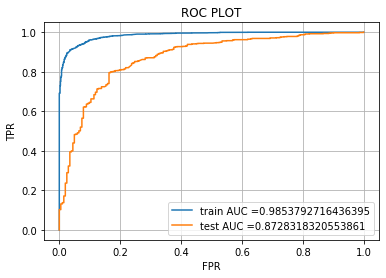

---------------------------------------------------
the maximum value of tpr*(1-fpr) 0.8782708309145091 for threshold 0.76
Train confusion matrix


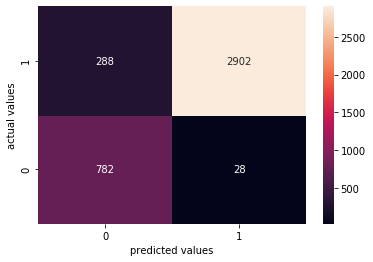

Test confusion matrix


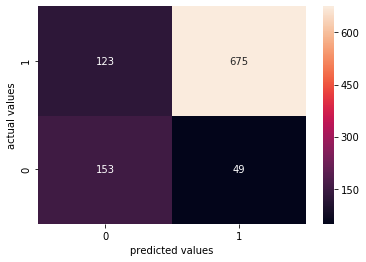

In [8]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import seaborn as sns

neigh = xgb.XGBClassifier(max_depth=5,learning_rate=0.2,n_estimators= 100)
neigh.fit(train_cleanedtext, outputtrain)



y_train_pred = neigh.predict_proba(train_cleanedtext)[:,1]    
y_test_pred = neigh.predict_proba(test_cleanedtext)[:,1]
#print(y_test_pred)
train_fpr, train_tpr, tr_thresholds = roc_curve(outputtrain, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(outputtest, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOT")
plt.grid()
plt.show()


def bestthreshold(threshould, fpr, tpr):# function to predict best threshold
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predictusingbestt(proba, threshould):#prediction using best threshold
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

print("---------------------------------------------------")


from sklearn.metrics import confusion_matrix
best_t = bestthreshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")

ax=sns.heatmap(confusion_matrix(outputtrain, predictusingbestt(y_train_pred, best_t)),annot=True,fmt='d')
ax.set_ylim([0,2])
plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()
print("Test confusion matrix")


bx=sns.heatmap(confusion_matrix(outputtest, predictusingbestt(y_test_pred, best_t)),annot=True,fmt='d')
bx.set_ylim([0,2])
plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()